In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import pandas as pd
import sys
sys.path.append('./../../p-det-O3/')
from p_det_O3.emulator import *
sys.path.append("./../code/")
from training_routines import *
from draw_new_injections import draw_new_injections
import pickle
import tqdm
from figure_utilities import *

np.random.seed(230529)

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_27_weights.hdf5",
                scaler="./../data/trained_networks/job_27_input_scaler.pickle")

jitted_ann = jax.jit(ann)

In [4]:
injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
neff_inj = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_nn_hybrid = np.zeros(n)
semianalytic_effs = np.zeros(n)
neff_semianalytic = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i], _, neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)
    
    semianalytic_effs[i],neff_semianalytic[i] = get_semianalytic_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


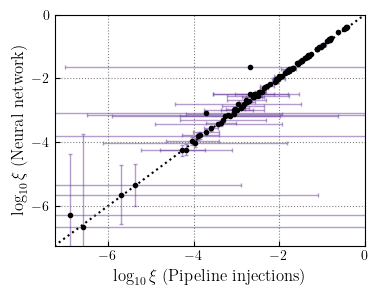

In [21]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

inj_errors = inj_stds/(np.log(10.)*inj_effs)
nn_errors = nn_stds/(np.log(10.)*nn_effs_hybrid)

fig,ax = plt.subplots(figsize=(4,3))
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(nn_effs_hybrid),
                                  xerr = inj_errors,
                                  yerr = nn_errors,
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.25,0.)
ax.set_ylim(-7.25,0.)
ax.set_yticks(np.arange(-6,1,2))
plt.savefig('figure_06.pdf',bbox_inches='tight')
plt.show()

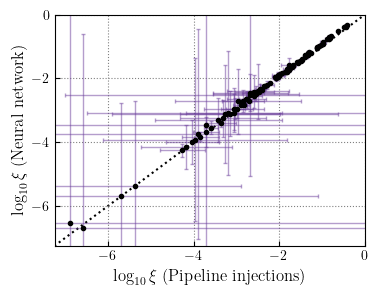

In [6]:
inj_stds = np.sqrt(inj_effs/neff_inj)
semianalytic_stds = np.sqrt(semianalytic_effs/neff_semianalytic)

inj_errors = inj_stds/(np.log(10.)*inj_effs)
semianalytic_errors = semianalytic_stds/(np.log(10.)*semianalytic_effs)

fig,ax = plt.subplots(figsize=(4,3))
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(semianalytic_effs),
                                  xerr = inj_errors,
                                  yerr = semianalytic_errors,
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.25,0.)
ax.set_ylim(-7.25,0.)
ax.set_yticks(np.arange(-6,1,2))
#plt.savefig('figure_06.pdf',bbox_inches='tight')
plt.show()

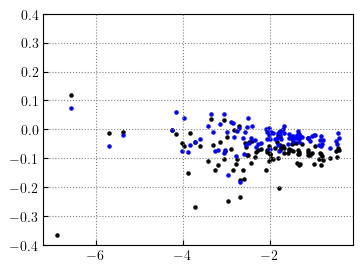

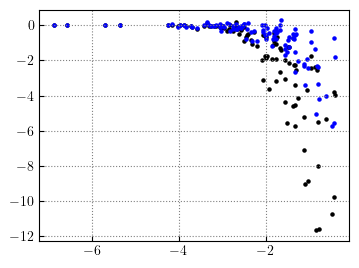

In [18]:
fig,ax = plt.subplots()
ax.scatter(np.log10(inj_effs), (np.log10(inj_effs)-np.log10(semianalytic_effs)), s=5, color='black')
ax.scatter(np.log10(inj_effs), (np.log10(inj_effs)-np.log10(nn_effs_hybrid)), s=5, color='blue')
ax.set_ylim(-0.4,0.4)
plt.show()

fig,ax = plt.subplots()
ax.scatter(np.log10(inj_effs), (np.log10(inj_effs)-np.log10(semianalytic_effs))/error2, s=5, color='black')
ax.scatter(np.log10(inj_effs), (np.log10(inj_effs)-np.log10(nn_effs_hybrid))/error1, s=5, color='blue')
plt.show()

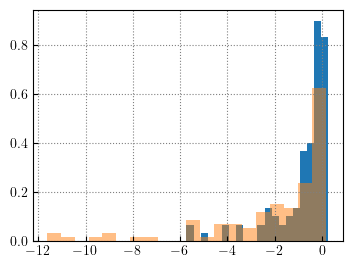

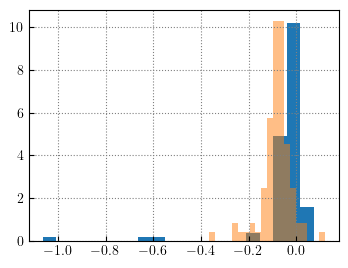

In [7]:
error1 = np.sqrt(nn_errors**2+inj_errors**2)
error2 = np.sqrt(semianalytic_errors**2+inj_errors**2)

fig,ax = plt.subplots()
ax.hist((np.log10(inj_effs)-np.log10(nn_effs_hybrid))/error1,density=True,bins=20)
ax.hist((np.log10(inj_effs)-np.log10(semianalytic_effs))/error2,density=True,bins=20,alpha=0.5)
plt.show()

fig,ax = plt.subplots()
ax.hist((np.log10(inj_effs)-np.log10(nn_effs_hybrid)),density=True,bins=20)
ax.hist((np.log10(inj_effs)-np.log10(semianalytic_effs)),density=True,bins=20,alpha=0.5)
plt.show()

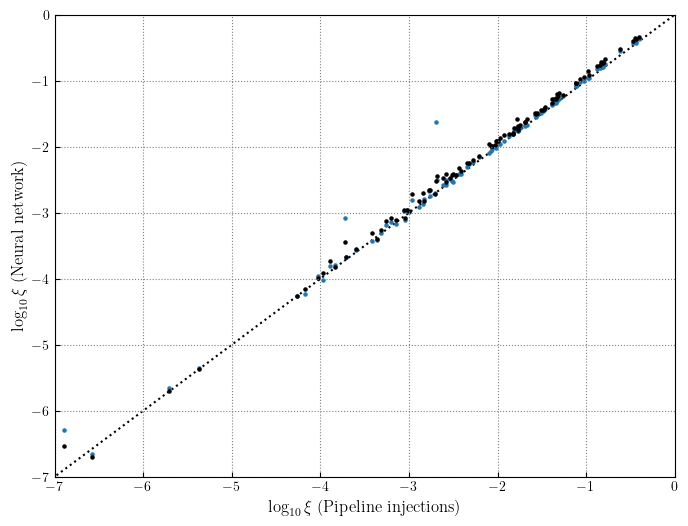

In [46]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)

ax.scatter(np.log10(inj_effs), np.log10(nn_effs_hybrid),s=5)

ax.scatter(np.log10(inj_effs), np.log10(semianalytic_effs),s=5,color='black')


ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7,0)
ax.set_ylim(-7,0)
plt.show()

 # Network 67

In [5]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_67_weights.hdf5",
                scaler="./../data/trained_networks/job_67_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i], _, neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]


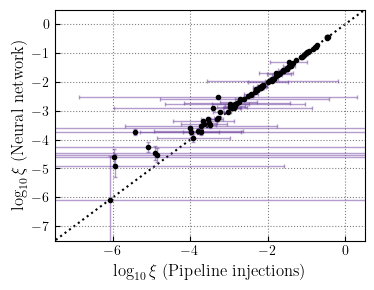

In [6]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

fig,ax = plt.subplots()
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(nn_effs_hybrid),
                                  xerr = inj_stds/(np.log(10.)*inj_effs),
                                  yerr = nn_stds/(np.log(10.)*nn_effs_hybrid),
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)
plt.show()

# Network 03

In [7]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_03_weights.hdf5",
                scaler="./../data/trained_networks/job_03_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i], _, neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


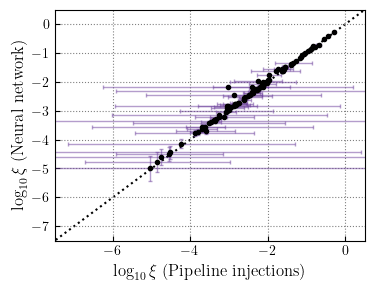

In [8]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

fig,ax = plt.subplots()
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(nn_effs_hybrid),
                                  xerr = inj_stds/(np.log(10.)*inj_effs),
                                  yerr = nn_stds/(np.log(10.)*nn_effs_hybrid),
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)
plt.show()

# Network 28

In [9]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_28_weights.hdf5",
                scaler="./../data/trained_networks/job_28_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i], _, neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


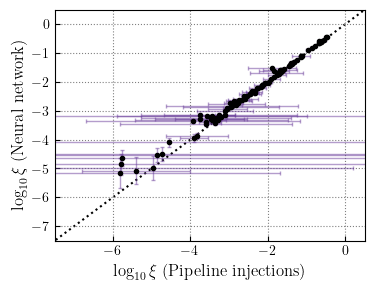

In [10]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

fig,ax = plt.subplots()
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(nn_effs_hybrid),
                                  xerr = inj_stds/(np.log(10.)*inj_effs),
                                  yerr = nn_stds/(np.log(10.)*nn_effs_hybrid),
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)
plt.show()

# Network 17

In [11]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_17_weights.hdf5",
                scaler="./../data/trained_networks/job_17_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i], _, neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


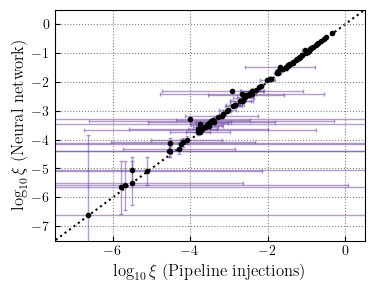

In [12]:
nn_stds = np.sqrt(nn_effs_hybrid/100000)
inj_stds = np.sqrt(inj_effs/neff_inj)

fig,ax = plt.subplots()
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
markers, caps, bars = ax.errorbar(np.log10(inj_effs), np.log10(nn_effs_hybrid),
                                  xerr = inj_stds/(np.log(10.)*inj_effs),
                                  yerr = nn_stds/(np.log(10.)*nn_effs_hybrid),
                                  marker='o',
                                  markerfacecolor='black',
                                  markeredgecolor='black',
                                  markersize=3,
                                  color=cmisc,
                                  zorder=2,
                                  ls='none',
                                  elinewidth=1.,
                                  capsize=1.5,
                                  capthick=1)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)
plt.show()